In [1]:
import json
import pandas as pd
import textwrap
from ipywidgets import widgets, HBox, VBox
from IPython.display import display, HTML
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import re

def jprint(obj):
    print(json.dumps(obj, indent=2))


# Evaluation Results Inspector

This notebook provides tools to inspect and analyze evaluation results from conversational multi-hop QA tasks.


## Data Loading Functions


In [2]:
def load_results(file_path):
    """Load evaluation results from a JSONL file"""
    results = []
    with open(file_path, "r") as f:
        for line in f:
            results.append(json.loads(line.strip()))
    return results


def results_to_dataframe(results):
    """Convert results to a pandas DataFrame with derived columns"""
    df = pd.DataFrame(results)

    # Extract key information
    df["question"] = df["prompt"].apply(lambda x: x[1]["content"].split("\n")[0] if len(x) > 1 else "")
    df["reference_answers"] = df["info"].map(lambda x: str(x["answers"]))
    df["n_hops"] = df["info"].map(lambda x: x["n_hops"])

    # Conversation analysis
    df["n_turns"] = df["completion"].apply(count_turns)
    df["n_tool_calls"] = df["completion"].apply(count_tool_calls)
    df["used_supporting_docs"] = df.apply(
        lambda row: check_supporting_docs_usage(row["completion"], row["info"]["docs"]), axis=1
    )

    df.rename(
        columns={
            "answer": "predicted_answer",
            "exact_match_reward": "exact_match",
            "f1_reward": "f1",
            "retrieval_recall_reward": "retrieval_recall",
        },
        inplace=True,
    )

    df.drop(columns=["reward"], inplace=True)

    return df


def extract_final_answer(completion):
    """Extract the final answer from the completion"""
    if not completion:
        return ""

    # Look for the last assistant message with an <answer> tag
    for message in reversed(completion):
        if message.get("role") == "assistant" and "content" in message:
            content = message["content"]
            # Extract text between <answer> tags
            answer_match = re.search(r"<answer>(.*?)</answer>", content, re.DOTALL)
            if answer_match:
                return answer_match.group(1).strip()

    return ""


def calculate_exact_match(predicted, ground_truth_list):
    """Calculate exact match score"""
    if not predicted:
        return 0

    predicted_clean = predicted.lower().strip()
    for gt in ground_truth_list:
        if predicted_clean == gt.lower().strip():
            return 1
    return 0


def count_turns(completion):
    """Count conversation turns"""
    return len([msg for msg in completion if msg.get("role") == "assistant"])


def count_tool_calls(completion):
    """Count total tool calls made"""
    count = 0
    for msg in completion:
        if msg.get("tool_calls"):
            count += len(msg["tool_calls"])
    return count


def check_supporting_docs_usage(completion, docs):
    """Check if supporting documents were retrieved and used"""
    supporting_doc_ids = [str(doc["id"]) for doc in docs if doc.get("is_supporting", False)]

    # Look for document IDs mentioned in tool responses
    used_doc_ids = set()
    for msg in completion:
        if msg.get("role") == "tool" and "content" in msg:
            content = msg["content"]
            # Extract document IDs from tool responses
            doc_id_matches = re.findall(r"Document ID: (\d+)", content)
            used_doc_ids.update(doc_id_matches)

    # Check how many supporting docs were used
    used_supporting = len(set(supporting_doc_ids) & used_doc_ids)
    total_supporting = len(supporting_doc_ids)

    return used_supporting / total_supporting if total_supporting > 0 else 0


## Load and Process Data


In [3]:
# Load your results file
results_file = "../outputs/evaluation-results.jsonl"  # Change this to your actual results file
results = load_results(results_file)
df = results_to_dataframe(results)

print(f"Loaded {len(df)} evaluation results")
df.head()


Loaded 300 evaluation results


,prompt,completion,predicted_answer,info,task,exact_match,f1,retrieval_recall,citation_reward,format_reward,combined_reward,question,reference_answers,n_hops,n_turns,n_tool_calls,used_supporting_docs
0,[{'content': 'Answer the question based on the...,[{'content': '<think> The question is about a ...,LeMat revolver,"{'answers': ['LeMat Revolver', 'lemat revolver...",default,0.0,0.000000,0.500000,0.000000,1.000000,0.100000,What gun was used by Pollack's director in Wes...,"['LeMat Revolver', 'lemat revolver', 'LeMat re...",2,4,3,0.500000
1,[{'content': 'Answer the question based on the...,[{'content': '<think> To find the Vice-Preside...,Vitor Constâncio,"{'answers': ['Vitor Constâncio', 'vitor constâ...",default,0.0,0.235294,1.000000,0.500000,0.666667,0.290850,Who is the Vice-President of the organization ...,"['Vitor Constâncio', 'vitor constâncio']",2,3,2,1.000000
2,[{'content': 'Answer the question based on the...,"[{'content': '<think> First, I need to identif...",the Politburo,"{'answers': ['politburo', 'the Politburo', 'th...",default,0.0,0.000000,0.666667,0.333333,0.666667,0.177778,Where did the person who argued that the count...,"['politburo', 'the Politburo', 'the politburo'...",3,2,1,0.666667
3,[{'content': 'Answer the question based on the...,"[{'content': '<think> To solve this, I need to...",Cabarrus County,"{'answers': ['cabarrus county', 'Cabarrus Coun...",default,0.0,0.153846,0.750000,0.000000,1.000000,0.144872,What county shares a border with the county wh...,"['cabarrus county', 'Cabarrus County']",4,3,2,0.750000
4,[{'content': 'Answer the question based on the...,[{'content': '<think> To find the distance fro...,45,"{'answers': ['45'], 'docs': [{'body': 'Weber C...",default,0.0,0.111111,1.000000,0.500000,1.000000,0.283333,What is the distance in miles from Nashville t...,['45'],2,4,3,1.000000


In [4]:
df.columns

Index(['prompt', 'completion', 'predicted_answer', 'info', 'task',
       'exact_match', 'f1', 'retrieval_recall', 'citation_reward',
       'format_reward', 'combined_reward', 'question', 'reference_answers',
       'n_hops', 'n_turns', 'n_tool_calls', 'used_supporting_docs'],
      dtype='object')

In [5]:
# Enhanced reward metrics display
def show_reward_breakdown(df):
    print("=== DETAILED REWARD BREAKDOWN ===")
    reward_cols = [
        "exact_match_reward",
        "f1_reward",
        "retrieval_recall_reward",
        "citation_reward",
        "format_reward",
        "combined_reward",
    ]

    for col in reward_cols:
        if col in df.columns:
            print(f"{col}: {df[col].mean():.3f} ± {df[col].std():.3f}")


show_reward_breakdown(df)


=== DETAILED REWARD BREAKDOWN ===
citation_reward: 0.463 ± 0.306
format_reward: 0.711 ± 0.233
combined_reward: 0.241 ± 0.128


## Summary Statistics


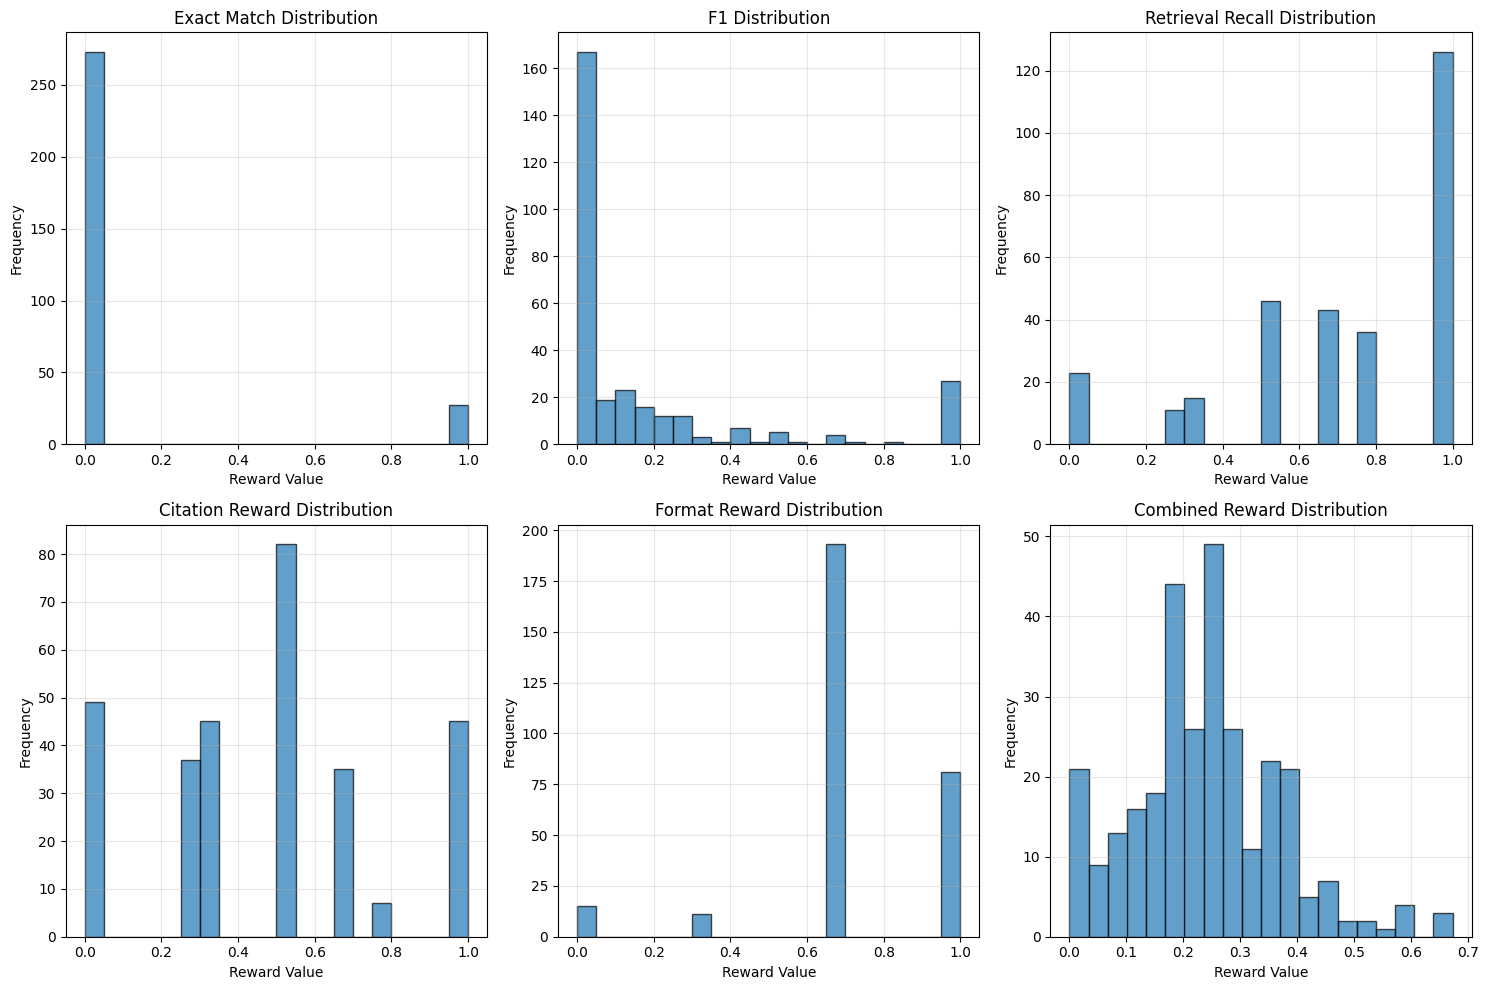

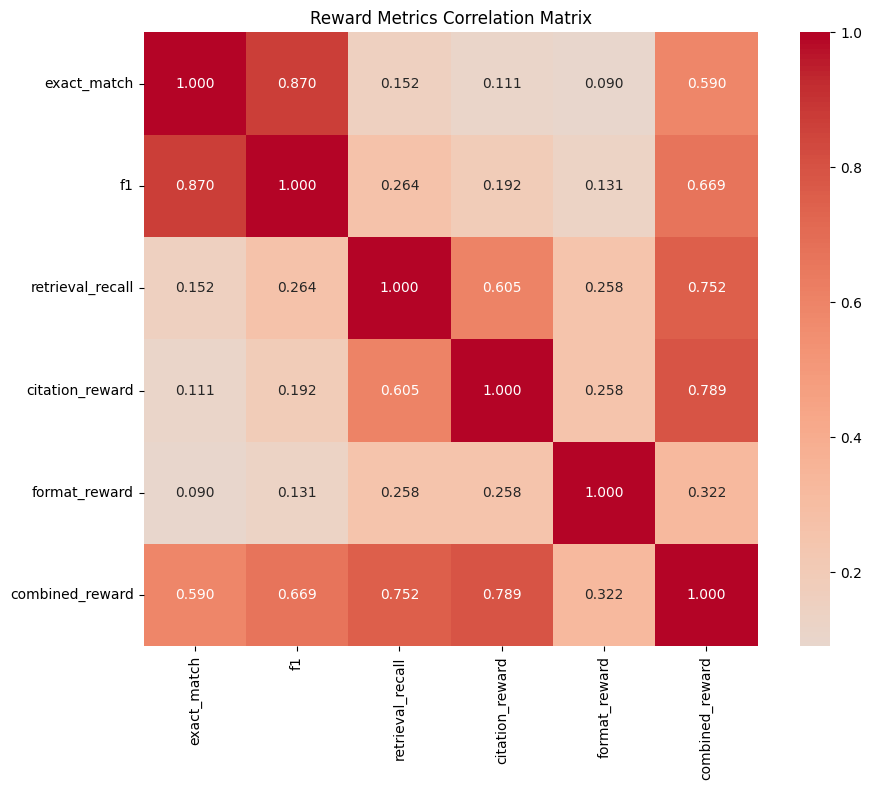

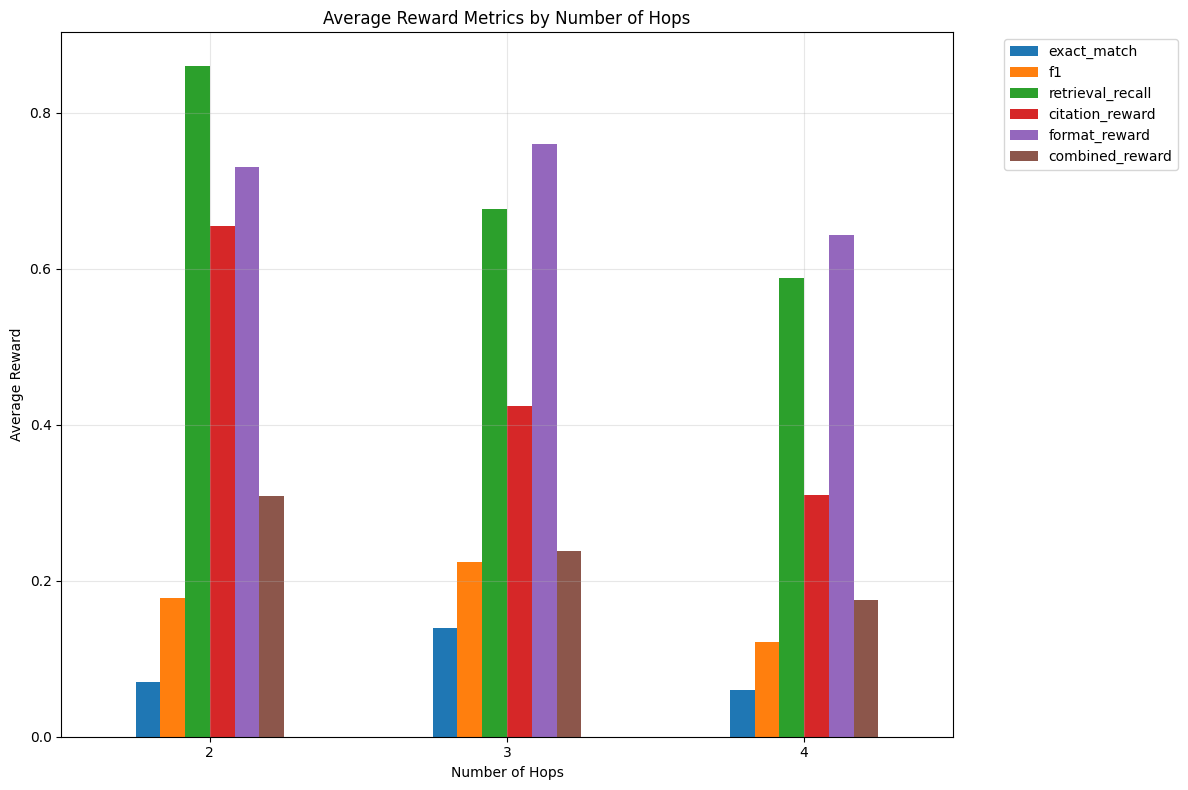

In [6]:
# Enhanced visualizations with reward metrics

# Create reward comparison plots
reward_cols = [
    "exact_match",
    "f1",
    "retrieval_recall",
    "citation_reward",
    "format_reward",
    "combined_reward",
]
available_rewards = [col for col in reward_cols if col in df.columns]

if len(available_rewards) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # Reward distributions
    for i, col in enumerate(available_rewards):
        if i < len(axes):
            axes[i].hist(df[col], bins=20, alpha=0.7, edgecolor="black")
            axes[i].set_title(f"{col.replace('_', ' ').title()} Distribution")
            axes[i].set_xlabel("Reward Value")
            axes[i].set_ylabel("Frequency")
            axes[i].grid(True, alpha=0.3)

    # Hide unused subplots
    for i in range(len(available_rewards), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Correlation heatmap of reward metrics
    if len(available_rewards) > 1:
        plt.figure(figsize=(10, 8))
        reward_corr = df[available_rewards].corr()
        sns.heatmap(reward_corr, annot=True, cmap="coolwarm", center=0, fmt=".3f", square=True)
        plt.title("Reward Metrics Correlation Matrix")
        plt.tight_layout()
        plt.show()

    # Reward metrics by number of hops
    plt.figure(figsize=(12, 8))
    hop_groups = df.groupby("n_hops")[available_rewards].mean()
    hop_groups.plot(kind="bar", ax=plt.gca())
    plt.title("Average Reward Metrics by Number of Hops")
    plt.xlabel("Number of Hops")
    plt.ylabel("Average Reward")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.xticks(rotation=0)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

else:
    print("No detailed reward columns found in dataset")


## Visualization


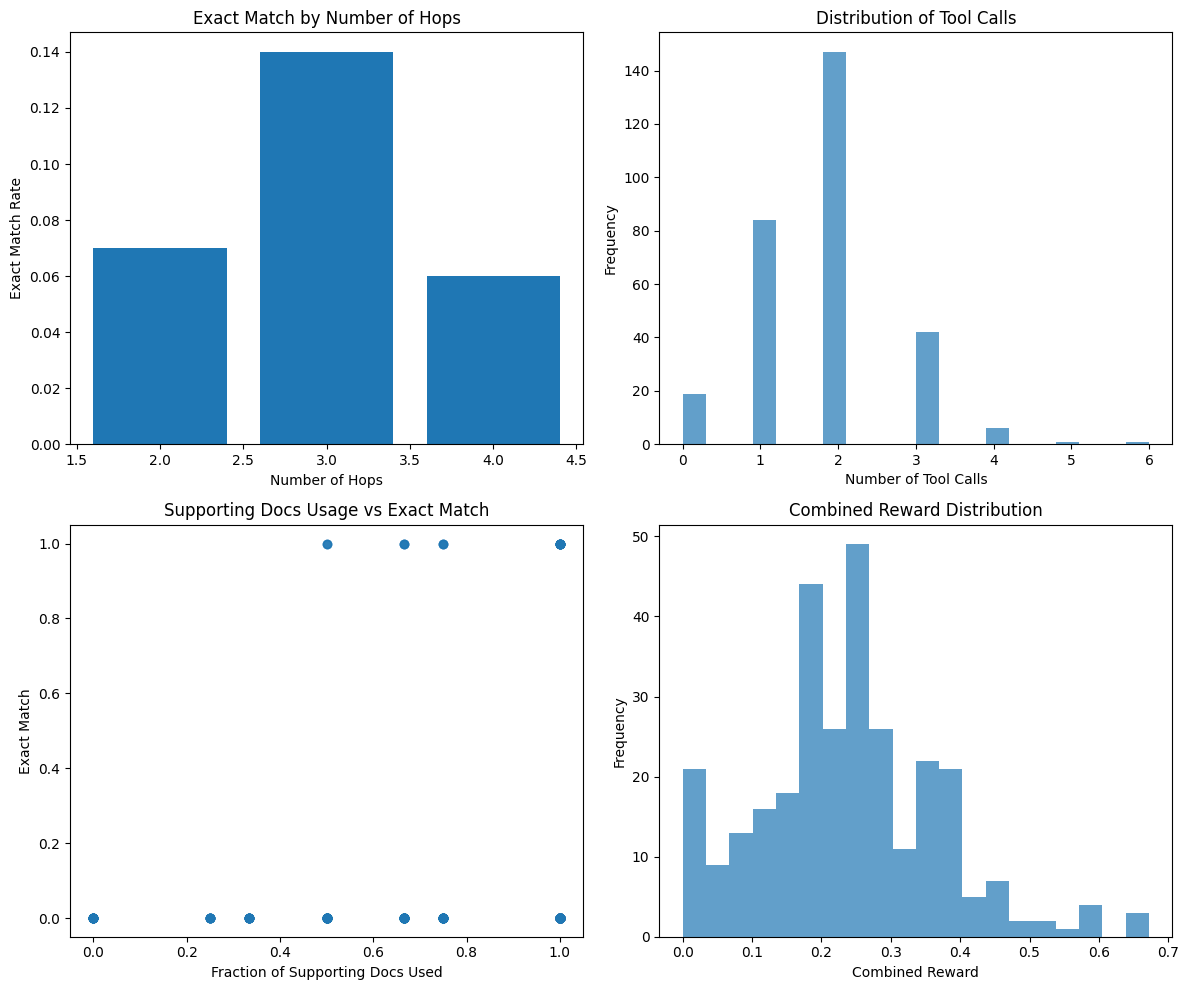

In [8]:
# Performance by number of hops
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Exact match by hops
hop_performance = df.groupby('n_hops')['exact_match'].mean()
axes[0,0].bar(hop_performance.index, hop_performance.values)
axes[0,0].set_title('Exact Match by Number of Hops')
axes[0,0].set_xlabel('Number of Hops')
axes[0,0].set_ylabel('Exact Match Rate')

# Tool calls distribution
axes[0,1].hist(df['n_tool_calls'], bins=20, alpha=0.7)
axes[0,1].set_title('Distribution of Tool Calls')
axes[0,1].set_xlabel('Number of Tool Calls')
axes[0,1].set_ylabel('Frequency')

# Supporting docs usage vs performance
axes[1,0].scatter(df['used_supporting_docs'], df['exact_match'], alpha=0.6)
axes[1,0].set_title('Supporting Docs Usage vs Exact Match')
axes[1,0].set_xlabel('Fraction of Supporting Docs Used')
axes[1,0].set_ylabel('Exact Match')

# Reward distribution
axes[1,1].hist(df['combined_reward'], bins=20, alpha=0.7)
axes[1,1].set_title('Combined Reward Distribution')
axes[1,1].set_xlabel('Combined Reward')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## Interactive Browser


In [26]:
# Enhanced format_example function to include all reward metrics

import textwrap


def wrap_text(text, width=120):
    return "\n\n".join(textwrap.wrap(text, width=width))


def format_documents(docs):
    """Format document information"""
    doc_info = []
    for doc in docs:
        support_status = "✅ Supporting" if doc.get("is_supporting", False) else "❌ Non-supporting"
        title = doc.get("title", "No title")
        doc_info.append(f"Doc {doc['id']}: {title} ({support_status})")
    return "\n".join(doc_info)


def format_conversation(conversation):
    """Format conversation for display"""
    return "\n\n\n".join([f"{msg['role']}: {wrap_text(msg['content'])}" for msg in conversation])


def format_example_enhanced(row):
    """Format a single example for display with all reward metrics"""

    # Basic information
    data = [
        ["Question", wrap_text(row["question"])],
        ["Ground Truth", str(row["info"]["answers"])],
        ["Predicted", row["predicted_answer"]],
        ["Exact Match", "✅ Yes" if row["exact_match"] else "❌ No"],
        ["", ""],  # Separator
    ]

    # Add all reward metrics
    reward_metrics = [
        ("Combined Reward", "combined_reward"),
        ("Exact Match", "exact_match_reward"),
        ("F1 Score", "f1_reward"),
        ("Retrieval Recall", "retrieval_recall_reward"),
        ("Citation Reward", "citation_reward"),
        ("Format Reward", "format_reward"),
    ]

    data.append(["=== REWARD BREAKDOWN ===", ""])
    for name, col in reward_metrics:
        if col in row and pd.notnull(row[col]):
            data.append([name, f"{row[col]:.3f}"])

    # Task and conversation info
    data.extend(
        [
            ["", ""],  # Separator
            ["Task", row.get("task", "default")],
            ["Hops", str(row["n_hops"])],
            ["Turns", str(row["n_turns"])],
            ["Tool Calls", str(row["n_tool_calls"])],
            ["Supporting Docs Used", f"{row['used_supporting_docs']:.1%}"],
            ["", ""],  # Separator
            ["Available Documents", format_documents(row["info"]["docs"])],
            ["", ""],  # Separator
            ["Conversation", format_conversation(row["completion"])],
        ]
    )

    return tabulate(data, tablefmt="grid")


In [27]:
def create_enhanced_browser(df):
    """Create interactive browser for examples with reward metric filtering"""

    # Filters
    correct_only = widgets.Checkbox(description="Correct answers only", value=False)
    incorrect_only = widgets.Checkbox(description="Incorrect answers only", value=False)
    hop_filter = widgets.Dropdown(
        options=["All"] + sorted(df["n_hops"].unique().tolist()), value="All", description="Hops:"
    )

    # Reward threshold sliders
    reward_threshold = widgets.FloatSlider(
        value=0.0, min=0.0, max=1.0, step=0.1, description="Min Reward:"
    )

    f1_threshold = widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=0.1, description="Min F1:")

    # Navigation
    index_widget = widgets.IntText(value=0, description="Index:")
    prev_button = widgets.Button(description="Previous")
    next_button = widgets.Button(description="Next")
    random_button = widgets.Button(description="Random")

    # Output
    output = widgets.Output()

    def get_filtered_df():
        filtered_df = df.copy()

        if correct_only.value:
            filtered_df = filtered_df[filtered_df["exact_match"] == 1]
        elif incorrect_only.value:
            filtered_df = filtered_df[filtered_df["exact_match"] == 0]

        if hop_filter.value != "All":
            filtered_df = filtered_df[filtered_df["n_hops"] == hop_filter.value]

        # Apply reward thresholds
        if "combined_reward" in filtered_df.columns:
            filtered_df = filtered_df[filtered_df["combined_reward"] >= reward_threshold.value]
        if "f1_reward" in filtered_df.columns:
            filtered_df = filtered_df[filtered_df["f1_reward"] >= f1_threshold.value]

        return filtered_df.reset_index(drop=True)

    def update_display():
        filtered_df = get_filtered_df()

        with output:
            output.clear_output()

            if len(filtered_df) == 0:
                print("No examples match the current filters.")
                return

            idx = max(0, min(index_widget.value, len(filtered_df) - 1))
            index_widget.value = idx

            print(f"Example {idx + 1} of {len(filtered_df)} (filtered)")
            print("=" * 120)
            print(format_example_enhanced(filtered_df.iloc[idx]))

    def on_prev_clicked(b):
        index_widget.value = max(0, index_widget.value - 1)

    def on_next_clicked(b):
        filtered_df = get_filtered_df()
        index_widget.value = min(len(filtered_df) - 1, index_widget.value + 1)

    def on_random_clicked(b):
        filtered_df = get_filtered_df()
        if len(filtered_df) > 0:
            import numpy as np

            index_widget.value = np.random.randint(0, len(filtered_df))

    # Wire up events
    prev_button.on_click(on_prev_clicked)
    next_button.on_click(on_next_clicked)
    random_button.on_click(on_random_clicked)

    # Update display when any control changes
    widgets.interactive_output(
        lambda *args: update_display(),
        {
            "idx": index_widget,
            "correct": correct_only,
            "incorrect": incorrect_only,
            "hops": hop_filter,
            "reward_thresh": reward_threshold,
            "f1_thresh": f1_threshold,
        },
    )

    # Layout
    filters = HBox([correct_only, incorrect_only, hop_filter])
    thresholds = HBox([reward_threshold, f1_threshold])
    navigation = HBox([prev_button, index_widget, next_button, random_button])

    display(VBox([filters, thresholds, navigation, output]))

    # Initial display
    update_display()


# Create the enhanced browser
create_enhanced_browser(df)


In [28]:
# Enhanced error analysis with reward breakdown


def analyze_errors_enhanced(df):
    """Analyze common error patterns with detailed reward breakdown"""
    incorrect = df[df["exact_match"] == 0]

    print(f"=== ENHANCED ERROR ANALYSIS ({len(incorrect)} incorrect examples) ===")

    # By number of hops
    print("\nError rate by hops:")
    hop_errors = df.groupby("n_hops").agg({"exact_match": lambda x: 1 - x.mean()}).round(3)
    print(hop_errors)

    # Reward component analysis
    print("\n=== REWARD COMPONENT ANALYSIS ===")
    reward_cols = [
        "exact_match_reward",
        "f1",
        "retrieval_recall",
        "citation_reward",
        "format_reward",
        "combined_reward",
    ]

    comparison_data = []
    for col in reward_cols:
        if col in df.columns:
            correct_mean = df[df["exact_match"] == 1][col].mean()
            incorrect_mean = df[df["exact_match"] == 0][col].mean()
            comparison_data.append(
                [
                    col.replace("_", " ").title(),
                    f"{correct_mean:.3f}",
                    f"{incorrect_mean:.3f}",
                    f"{correct_mean - incorrect_mean:+.3f}",
                ]
            )

    if comparison_data:
        print(tabulate(comparison_data, headers=["Metric", "Correct", "Incorrect", "Difference"], tablefmt="grid"))

    # Supporting document usage
    print("\n=== SUPPORTING DOCUMENT USAGE ===")
    print(f"Correct answers: {df[df['exact_match'] == 1]['used_supporting_docs'].mean():.3f}")
    print(f"Incorrect answers: {df[df['exact_match'] == 0]['used_supporting_docs'].mean():.3f}")

    # Tool call patterns
    print("\n=== TOOL CALL PATTERNS ===")
    print(f"Correct answers avg tool calls: {df[df['exact_match'] == 1]['n_tool_calls'].mean():.1f}")
    print(f"Incorrect answers avg tool calls: {df[df['exact_match'] == 0]['n_tool_calls'].mean():.1f}")

    # Examples with no predicted answer
    no_answer = df[df["predicted_answer"] == ""]
    print(f"\nExamples with no predicted answer: {len(no_answer)} ({len(no_answer) / len(df) * 100:.1f}%)")

    # Identify low-performing areas
    print("\n=== LOW-PERFORMING AREAS ===")
    if "retrieval_recall" in df.columns:
        low_retrieval = df[df["retrieval_recall"] < 0.5]
        print(f"Low retrieval recall (<0.5): {len(low_retrieval)} examples ({len(low_retrieval) / len(df) * 100:.1f}%)")

    if "citation_reward" in df.columns:
        low_citation = df[df["citation_reward"] < 0.5]
        print(f"Low citation quality (<0.5): {len(low_citation)} examples ({len(low_citation) / len(df) * 100:.1f}%)")

    if "format_reward" in df.columns:
        low_format = df[df["format_reward"] < 0.5]
        print(f"Low format compliance (<0.5): {len(low_format)} examples ({len(low_format) / len(df) * 100:.1f}%)")

    return incorrect


error_df_enhanced = analyze_errors_enhanced(df)


=== ENHANCED ERROR ANALYSIS (273 incorrect examples) ===

Error rate by hops:
        exact_match
n_hops             
2              0.93
3              0.86
4              0.94

=== REWARD COMPONENT ANALYSIS ===
+------------------+-----------+-------------+--------------+
| Metric           |   Correct |   Incorrect |   Difference |
+==================+===========+=============+==============+
| F1               |     1     |       0.093 |        0.907 |
+------------------+-----------+-------------+--------------+
| Retrieval Recall |     0.858 |       0.693 |        0.165 |
+------------------+-----------+-------------+--------------+
| Citation Reward  |     0.571 |       0.452 |        0.119 |
+------------------+-----------+-------------+--------------+
| Format Reward    |     0.778 |       0.705 |        0.073 |
+------------------+-----------+-------------+--------------+
| Combined Reward  |     0.481 |       0.217 |        0.264 |
+------------------+-----------+-----------

In [ ]:
# Summary of new features for the enhanced dataset

print("=== ENHANCED EVALUATION RESULTS INSPECTOR ===")
print("This notebook now supports the new dataset structure with detailed reward metrics!")
print()
print("NEW FEATURES:")
print("• Detailed reward breakdown (exact_match_reward, f1_reward, retrieval_recall_reward, etc.)")
print("• Enhanced visualizations showing reward correlations and distributions")
print("• Interactive browser with reward-based filtering")
print("• Improved error analysis comparing reward components")
print("• Backward compatibility with legacy datasets")
print()
print("AVAILABLE REWARD METRICS:")
reward_cols = ["reward", "exact_match", "f1", "retrieval_recall", "citation_reward", "format_reward"]
for col in reward_cols:
    if col in df.columns:
        print(f"  ✅ {col}")
    else:
        print(f"  ❌ {col} (not found in dataset)")

print()
print("To explore your data:")
print("1. Check the reward breakdown above")
print("2. Run the enhanced visualizations")
print("3. Use the interactive browser with reward filtering")
print("4. Analyze error patterns by reward components")


=== ENHANCED EVALUATION RESULTS INSPECTOR ===
This notebook now supports the new dataset structure with detailed reward metrics!

NEW FEATURES:
• Detailed reward breakdown (exact_match_reward, f1_reward, retrieval_recall_reward, etc.)
• Enhanced visualizations showing reward correlations and distributions
• Interactive browser with reward-based filtering
• Improved error analysis comparing reward components
• Backward compatibility with legacy datasets

AVAILABLE REWARD METRICS:
  ✅ reward
  ✅ exact_match
  ✅ f1
  ✅ retrieval_recall
  ✅ citation_reward
  ✅ format_reward

To explore your data:
1. Check the reward breakdown above
2. Run the enhanced visualizations
3. Use the interactive browser with reward filtering
4. Analyze error patterns by reward components


## Error Analysis


In [ ]:
def analyze_errors(df):
    """Analyze common error patterns"""
    incorrect = df[df['exact_match'] == 0]
    
    print(f"=== ERROR ANALYSIS ({len(incorrect)} incorrect examples) ===")
    
    # By number of hops
    print("\nError rate by hops:")
    hop_errors = df.groupby('n_hops').agg({
        'exact_match': lambda x: 1 - x.mean()
    }).round(3)
    print(hop_errors)
    
    # Supporting document usage
    print("\nSupporting document usage comparison:")
    print(f"Correct answers: {df[df['exact_match']==1]['used_supporting_docs'].mean():.3f}")
    print(f"Incorrect answers: {df[df['exact_match']==0]['used_supporting_docs'].mean():.3f}")
    
    # Tool call patterns
    print("\nTool call patterns:")
    print(f"Correct answers avg tool calls: {df[df['exact_match']==1]['n_tool_calls'].mean():.1f}")
    print(f"Incorrect answers avg tool calls: {df[df['exact_match']==0]['n_tool_calls'].mean():.1f}")
    
    # Examples with no predicted answer
    no_answer = df[df['predicted_answer'] == '']
    print(f"\nExamples with no predicted answer: {len(no_answer)} ({len(no_answer)/len(df)*100:.1f}%)")
    
    return incorrect

error_df = analyze_errors(df)


=== ERROR ANALYSIS (273 incorrect examples) ===

Error rate by hops:
        exact_match
n_hops             
2              0.93
3              0.86
4              0.94

Supporting document usage comparison:
Correct answers: 0.858
Incorrect answers: 0.693

Tool call patterns:
Correct answers avg tool calls: 1.9
Incorrect answers avg tool calls: 1.8

Examples with no predicted answer: 0 (0.0%)


## Custom Analysis


In [ ]:
# Add your custom analysis here
# For example, analyze specific question types, patterns in tool usage, etc.

# Example: Look at questions that require exactly 2 hops
two_hop_questions = df[df['n_hops'] == 2]
print(f"2-hop questions performance: {two_hop_questions['exact_match'].mean():.3f}")

# Example: Correlation between tool calls and performance
correlation = df['n_tool_calls'].corr(df['exact_match'])
print(f"Correlation between tool calls and exact match: {correlation:.3f}")

# Example: Most common failure modes
print("\nMost common failure cases (first 5):")
failed_examples = df[df['exact_match'] == 0].head()
for idx, row in failed_examples.iterrows():
    print(f"- Question: {row['question'][:100]}...")
    print(f"  Predicted: '{row['predicted_answer']}'")
    print(f"  Expected: {row['info']['answers']}")
    print()


2-hop questions performance: 0.070
Correlation between tool calls and exact match: 0.033

Most common failure cases (first 5):
- Question: What gun was used by Pollack's director in Westworld?...
  Predicted: 'LeMat revolver'
  Expected: ['LeMat Revolver', 'lemat revolver', 'LeMat revolver']

- Question: Who is the Vice-President of the organization that controls the monetary policy of the EU?...
  Predicted: 'Vitor Constâncio'
  Expected: ['Vitor Constâncio', 'vitor constâncio']

- Question: Where did the person who argued that the country that Mark Fradkin is a citizen of had become an imp...
  Predicted: 'the Politburo'
  Expected: ['politburo', 'the Politburo', 'the politburo', 'Politburo']

- Question: What county shares a border with the county where the singer of Hungry Eyes from the movie Dirty Dan...
  Predicted: 'Cabarrus County'
  Expected: ['cabarrus county', 'Cabarrus County']

- Question: What is the distance in miles from Nashville to the place where Hemlock Semiconducto